# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

## <font color="red">*Pitch Your Project*</font>

<font color="red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

# ***What?*** 
<200 words </font>

The question: What are the most sailent differences between the left and right-leaned news media?

The text: tweets from the official accounts of 5 left-skewed news media (CNN, Daily Beast, Jacobin, Democracy Now, and Huffpost) and 5 right-skewed news media (Fox News, Breitbart, National Review, The American Spectator, and New York Post Opinion).


## <font color="red">***Why?***
<200 words
</font>

The deep partisan division has caused many concerns across the country. Such division may lead to increasing polarization of the people, and such polarization may eventrually results in disagreement in important issues, not only in political issues like election, but also in events demand corporation, such as combating the pandemic. Therefore, it's theoretically and practially important to understand what the news media of the two parties are arguing, asserting, persuading and disseminating.

## <font color="red"> ***How?***
<400 words
</font>

* **Data collection**: The tweets used in this project will be collected through web-scrapping with the "snscrape" python package.
* **Difference in topics (topic modeling)**: I will first collect 5000 tweets from each of the 10 media listed above (hereinafter "no-keyword tweets set"). Then, I will use topic modeling techniques to explore what have been the focus in different media, and if there are noticable difference in topics between the two parties. Both topic modeling techniquies like LDA and clustering tools like K-means will be employed. I intend to use clustering as a complement for topic modeling, because it can help me spot salient topics by identifying salient words.
* **Disagreement on narrarates of specific issues (Word embedding)**: For 5 important issues today in the US, I want to explore how media of either party has been describing them with word embedding. Specifically, the issues I want to focus on are:
    - The COVID-19 pandemic (keyword: "covid")
    - Health care (keyword: "health care")
    - Immigration (keyword: "immigrant","immigrants")
    - Environment (keyword: "climate", "environment")
    - Drug addiction (keyword: "drug addiction")

I may adjust the issue list after observing the results from topic modeling. In this part, I will recollect the data to fit the question better. For each of the 5 issue and 10 media, I will collect 1000 tweets from each of the 10 media listed before, by searching for the keywords listed in the brackets hereinafter "keyworded tweets set". Thus, for each of the issue, I will get 10,000 tweets. Word embedding methods like word2vec will be used for this part. 
* **Most sailent features that tell the two parties apart (supervised learning on classification task)**: In this part, I want to explore whether I can use supervised learning algorithms to distinuish tweets from media of either political side. Multiple algorithms will be used to complete this task, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and neural network. By performing this classification traning, I wish to learn not only whether there are indeed dinstinguishable features between these two parties, but also what these features are. The latter question will be answered by observing the weights of features given by the learner. Both the no-keyword and keyworded tweets set will be used. The former is for studying the general differences, and the latter is for examining differences in specific issues.

## <font color="red">*Pitch Your Sample*</font>

<font color="red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).</font>

## <font color="red"> ***Which (words)?***
<300 words
</font>

1. **Rationale and virtues:** I choose to use tweets from the official accounts of news media primarily for convinence. The "snscrape" package excellently support me to scrape historical tweets and parse them in an easier way, especially compared to parsing web content. Besides, though the content published by news media on twitter may not be completely the same as to their website. However, this may also comprise the advantages of this sample source. When the number of words is limited to less than 140, the news media may want to convey the central ideas straightforward. And such straightforwardness would potentially benefit my topic modelling, word embedding and classification tasks by reducing noises.
2. **Limitations and further explore:** The most significant limitation is the sample size, and the time period and the number of media it covered. An ideal and comprehensively project may want to extend to time period of scrapping to three years. Scaling up across time will also enable the researcher to explore the dynamics in political leaningness of the media.

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [2]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [4]:
dataDir = 'C:/Users/86188/Desktop/SOCI 40133/Homework-Notebooks/data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
10,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington ...
20,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Fact sheet...
30,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington ...
40,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE BOSTON MA Se...
50,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington ...
60,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE The President ...
70,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington DC...
80,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
90,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE The Preside...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,category,filePath,text,tokenized_sents,normalized_sents
0,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
10,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, d, c, today,..."
20,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Fact sheet...,"[[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...","[[immediate, release, fact, sheets, bush, s, p..."
30,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, d, c, today,..."
40,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE BOSTON MA Se...,"[[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator...","[[immediate, release, boston, ma, senator, edw..."
50,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...","[[immediate, release, washington, dc, today, s..."
60,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE The President ...,"[[FOR, IMMEDIATE, RELEASE, The, President, is,...","[[immediate, release, president, wrong, veto, ..."
70,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Sen...","[[immediate, release, washington, dc, senators..."
80,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release], [im..."
90,Kennedy,C:/Users/86188/Desktop/SOCI 40133/Homework-Not...,FOR IMMEDIATE RELEASE The Preside...,"[[FOR, IMMEDIATE, RELEASE, The, President, gav...","[[immediate, release, president, gave, effecti..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [10]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [14]:
senReleasesW2V.wv['president'][:10] #Shortening because it's very large

array([-1.71014   , -0.27194947, -0.36441615, -0.01600786,  0.5794832 ,
       -0.11314717,  2.0115817 ,  0.12391191, -2.4138012 ,  0.43280134],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [16]:
senReleasesW2V.wv.vectors

array([[ 0.8325407 ,  0.60433686,  0.02425952, ..., -1.0441065 ,
         0.4681976 ,  0.55555487],
       [-1.7855607 ,  0.55776066,  1.3171917 , ..., -1.5621772 ,
        -0.40275067, -0.26504013],
       [ 1.011031  ,  0.15708415, -0.28272262, ...,  0.6210944 ,
         0.55829275,  0.07233895],
       ...,
       [-0.0544708 ,  0.06878538, -0.02047567, ..., -0.08243857,
         0.03919413,  0.017321  ],
       [-0.06507875,  0.02066711,  0.0077896 , ..., -0.0192016 ,
         0.02420831,  0.03061132],
       [-0.0212227 ,  0.07029413,  0.04906391, ..., -0.05253877,
         0.03855624,  0.01957916]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [18]:
senReleasesW2V.wv.index_to_key[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [20]:
senReleasesW2V.wv.most_similar('president')

[('administration', 0.7770196199417114),
 ('presidents', 0.71745365858078),
 ('administrations', 0.6769723892211914),
 ('kenna', 0.5785647630691528),
 ('cheney', 0.5635040402412415),
 ('george', 0.5620718002319336),
 ('linean', 0.5615614056587219),
 ('responds', 0.5169224739074707),
 ('ronald', 0.5117853879928589),
 ('mcnulty', 0.5112334489822388)]

In [21]:
senReleasesW2V.wv.most_similar('war')

[('wars', 0.6786377429962158),
 ('afghanistan', 0.651370108127594),
 ('quagmire', 0.636921226978302),
 ('disobedience', 0.62158203125),
 ('unresisted', 0.6160163283348083),
 ('chaos', 0.608697235584259),
 ('foment', 0.598943829536438),
 ('invasion', 0.5875676274299622),
 ('insurgency', 0.585807204246521),
 ('chose', 0.5813125967979431)]

Find which word least matches the others within a word set (cosine similarity):

In [23]:
senReleasesW2V.wv.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [24]:
senReleasesW2V.wv.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('veto', 0.6110351085662842),
 ('bush', 0.6056764125823975),
 ('signed', 0.5966927409172058),
 ('vetoed', 0.5904338955879211),
 ('signature', 0.5895500183105469),
 ('blocked', 0.5847731828689575),
 ('vetoes', 0.5777859687805176),
 ('bushs', 0.5766110420227051),
 ('proposing', 0.5588018298149109),
 ('signing', 0.5558163523674011)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [25]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [27]:
numWords = 50
targetWords = senReleasesW2V.wv.index_to_key[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [29]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.8325407 ,  0.60433686,  0.02425952, ..., -1.0441065 ,
         0.4681976 ,  0.55555487],
       [-1.7855607 ,  0.55776066,  1.3171917 , ..., -1.5621772 ,
        -0.40275067, -0.26504013],
       [ 1.011031  ,  0.15708415, -0.28272262, ...,  0.6210944 ,
         0.55829275,  0.07233895],
       ...,
       [-1.1549432 , -0.22477569,  0.98799205, ...,  0.66814816,
         2.1612506 , -0.8764157 ],
       [-0.7029938 ,  0.2548504 ,  0.10727413, ..., -0.32848167,
         0.78596354, -0.9677902 ],
       [-2.773999  , -1.1199813 , -0.3385636 , ..., -1.1255009 ,
        -0.19255802, -0.150282  ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [30]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

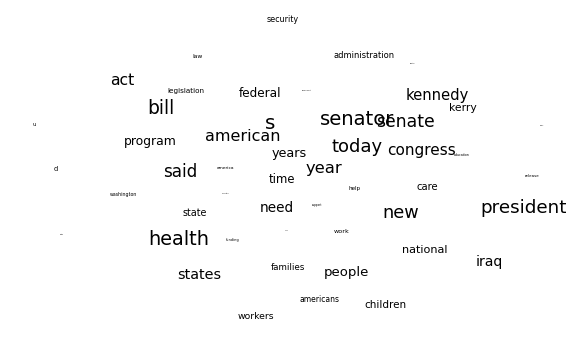

In [31]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [33]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from 'D:\\MySoftware\\python310\\lib\\site-packages\\gensim\\models\\word2vec.py'>

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [20]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [21]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [22]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [23]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [24]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## Adding more context - FastText

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText ([Bojanowski et al. 2017](https://arxiv.org/abs/1607.04606)), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. 

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [34]:
! pip install fasttext

  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
Using legacy 'setup.py install' for fasttext, since package 'wheel' is not installed.
    Running setup.py install for fasttext: started

    ERROR: Command errored out with exit status 1:
     command: 'D:\MySoftware\python310\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\86188\\AppData\\Local\\Temp\\pip-install-pd2vilrc\\fasttext_c809404f168241db95bc1c458c894546\\setup.py'"'"'; __file__='"'"'C:\\Users\\86188\\AppData\\Local\\Temp\\pip-install-pd2vilrc\\fasttext_c809404f168241db95bc1c458c894546\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record 'C:\Users\86188\AppData\Local\Temp\pip-record-dsjs1wp5\install-record.txt' --single-version-externally-managed --compile --install-headers 'D:\MySoftware\python310\Include\fasttext'
         cwd: C:\Users\86188\AppData\Local\Temp\pip-install-pd2vilrc\fasttext_c809404f168241db95bc1c458c894546\
    Com


    Running setup.py install for fasttext: finished with status 'error'


### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [Google Drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing). 

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [35]:
import fasttext

ModuleNotFoundError: No module named 'fasttext'

In [ ]:
# Replace with the path for where you have placed the 'fil9' file.
file_address = "/content/drive/MyDrive/fil9" 

In [ ]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [ ]:
model.words

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [ ]:
model.get_word_vector("the")

In [ ]:
model.save_model("result/fil9.bin")

In [ ]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [ ]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [ ]:
model.get_word_vector("enviroment")

In [ ]:
# Add FastText here

-------------

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

### The text

The text I want to use for this week's exercises is the tweets from 10 media, with 5 of them being left-skewed and 5 being right-skewed. I scrapped 1,000 tweets from each of the 10 media.

In [2]:
# Read the data
import pandas as pd
tweets_df = pd.read_csv('./data/week45_10media_df.csv')

### Task 1: Embedding (2 specifications) and visualization (each with two specifications)

In [3]:
tweets_df['tokenized_sents'] = tweets_df['Text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
tweets_df['normalized_sents'] = tweets_df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [68]:
left_df = tweets_df[:5005]
right_df = tweets_df[5005:]

In [70]:
leftW2V = gensim.models.word2vec.Word2Vec(left_df['normalized_sents'].sum(), sg=0)
rightW2V = gensim.models.word2vec.Word2Vec(right_df['normalized_sents'].sum(), sg=0)

#### Specification 1: Most similar words to "election"

In [17]:
leftW2V.wv.most_similar('election')

[('said', 0.9996758699417114),
 ('trump', 0.9996488690376282),
 ('workers', 0.999596118927002),
 ('people', 0.9995893836021423),
 ('says', 0.999588131904602),
 ('week', 0.9995793700218201),
 ('like', 0.9995790123939514),
 ('world', 0.9995759129524231),
 ('covid-19', 0.9995747208595276),
 ('friday', 0.9995676875114441)]

In [18]:
rightW2V.wv.most_similar('election')

[('covid', 0.9989767670631409),
 ('biden', 0.9988769888877869),
 ('american', 0.9988566040992737),
 ('state', 0.9988493323326111),
 ('new', 0.9988490343093872),
 ('china', 0.9988312125205994),
 ('year', 0.9988275766372681),
 ('border', 0.9988030791282654),
 ('democrats', 0.99880051612854),
 ('$', 0.9988003373146057)]

The most similar words to "election" in the corpus of left media are "trump", "workers", "people", "world"; while that for right meida are "biden", "american", "state", "china", "border", "democrats".

This provides us with several interesting piece of information:
1. Left media talks more about the right party, and vice versa. It may be a negative sign, that propogandas in american elections are more about attacking each other rather than emphasizing one's own position.
2. Left media tend to use "global" words like "people" and "world", and right media likes local words like "american" and "state".
3. Both parties concern about the COVID-19 pandemic.
4. The right media, in particular, talks a lot about China and border-related policies.

#### Specification 2: "trump" + "republican" - "democrat" = ?

In [26]:
leftW2V.wv.most_similar(positive=['trump', 'democrat'], negative = ['republican'])

[('class', 0.9883987903594971),
 ('despite', 0.9883347749710083),
 ('self', 0.9882825613021851),
 ('m', 0.9881678819656372),
 ('companies', 0.9881559014320374),
 ('right', 0.9881492853164673),
 ('senate', 0.9881331324577332),
 ('film', 0.9881011843681335),
 ('wednesday', 0.9880177974700928),
 ('singer', 0.9880062937736511)]

In [28]:
rightW2V.wv.most_similar(positive=['trump', 'democrat'], negative = ['republican'])

[('public', 0.9981098771095276),
 ('year', 0.9979700446128845),
 ('left', 0.9979097843170166),
 ('democrats', 0.9979016184806824),
 ('war', 0.9978851675987244),
 ('time', 0.9978820085525513),
 ('america', 0.997870922088623),
 ('mandate', 0.9978706240653992),
 ('like', 0.9978185892105103),
 ('biden', 0.9978064894676208)]

Obviously, when I typed down this command, I expect to get "biden". I did get it with the right corpus, but not in the left corpus. In the left corpus. the "distance" between "trump" and "republican" is more similar to that between "democrat" and "companies", "senate", "film" (and the senseless "right" and "singer"). Maybe it's because Biden is not the "star" as Obama or as Trump for the republican.

#### Visualization 1: PCA

In [33]:
numWords = 50

lefttargetWords = leftW2V.wv.index_to_key[:numWords]
leftwordsSubMatrix = []
for word in lefttargetWords:
    leftwordsSubMatrix.append(leftW2V.wv[word])
leftwordsSubMatrix = np.array(leftwordsSubMatrix)

righttargetWords = rightW2V.wv.index_to_key[:numWords]
rightwordsSubMatrix = []
for word in righttargetWords:
    rightwordsSubMatrix.append(rightW2V.wv[word])
rightwordsSubMatrix = np.array(rightwordsSubMatrix)

In [34]:
leftpcaWords = sklearn.decomposition.PCA(n_components = 50).fit_transform(leftwordsSubMatrix)
rightpcaWords = sklearn.decomposition.PCA(n_components = 50).fit_transform(rightwordsSubMatrix)

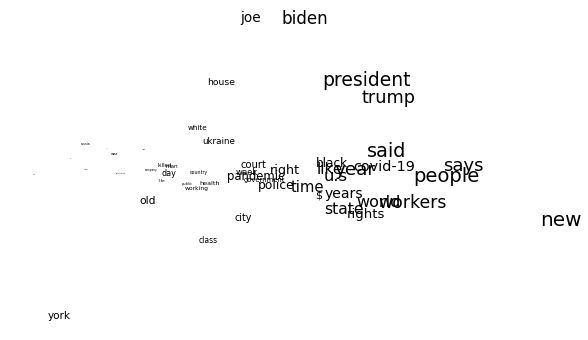

In [38]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(leftpcaWords[:, 0], leftpcaWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(lefttargetWords):
    ax.annotate(word, (leftpcaWords[:, 0][i],leftpcaWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

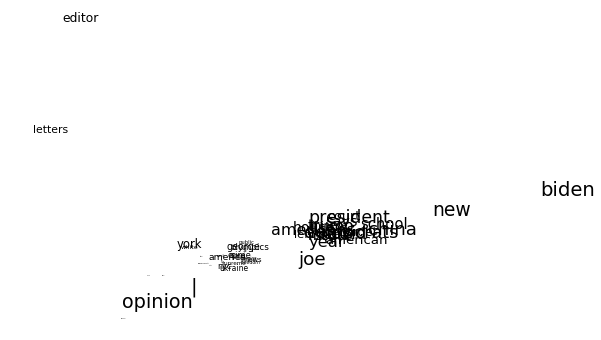

In [39]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(rightpcaWords[:, 0], rightpcaWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(righttargetWords):
    ax.annotate(word, (rightpcaWords[:, 0][i],rightpcaWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

The PCA successfully sparsed the first 50 words in the left corpus, but for the right corpus, the words just crashed to a mess. I guess the most obvious evidence that PCA didn't do a very good job is that the word "joe" and "biden" are so far away in the second graph. May be it's because "joe" could also be "joe ragan", but that doesn't explain why "joe" is so close to "president"

In [40]:
lefttsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(leftpcaWords)
righttsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(rightpcaWords)

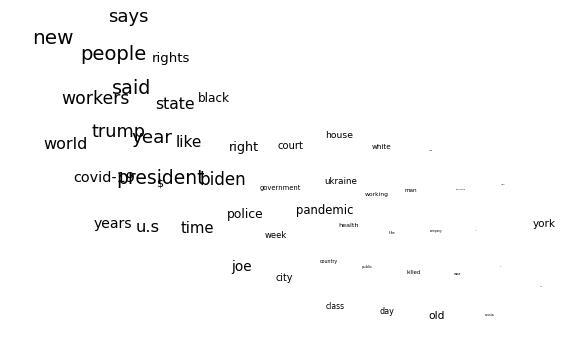

In [41]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(lefttsneWords[:, 0], lefttsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(lefttargetWords):
    ax.annotate(word, (lefttsneWords[:, 0][i],lefttsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

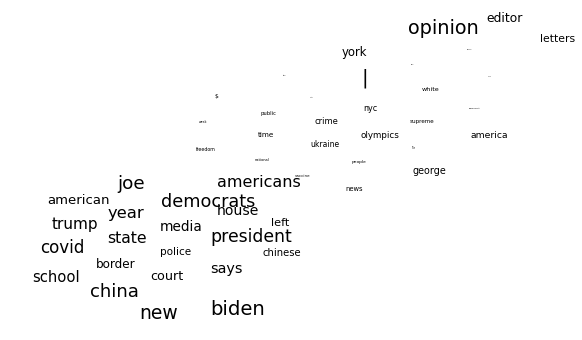

In [42]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(righttsneWords[:, 0], righttsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(righttargetWords):
    ax.annotate(word, (righttsneWords[:, 0][i],righttsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Beautiful! TSNE did such a great job in reducing the dimension while extract as much information as possible. It successfully sparsed the words in the two graphs.

Let's do a little bit analysis around the word "covid/covid-19" in the two graphs:
1. The word "covid-19" in the graph for the left media is close to "president", "biden" and "trump". It might imply that the left media take the COVID-19 related policies to be an important topic for this and the next government.
2. The word "covid" in the graph for the right media is close to "trump", "state", "border", "school". It's reasonable that "covid" is related with "state" and "school", but I personally have no idea why it is related with "border".

-----

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [44]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [45]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [46]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
D:\MySoftware\python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [53]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [55]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [56]:
apsD2V.docvecs[1952]

array([ 0.14340654,  2.1006963 , -0.7182573 ,  0.5233647 ,  0.25034875,
        0.95465094, -0.9017019 ,  1.1353799 ,  0.02445105, -0.43296334,
       -1.7721051 , -1.010405  , -0.5402075 , -0.48339784, -1.7452614 ,
       -0.11287308,  0.19208123,  1.5189297 ,  0.31903505, -1.0844508 ,
        1.0743654 ,  1.156734  , -0.04306236,  0.9525253 , -1.6919584 ,
       -0.67848843,  0.38926816,  0.5504286 ,  1.3652716 ,  1.5009022 ,
        0.4623844 , -0.5019375 , -1.0109348 ,  2.108322  , -1.3396758 ,
       -0.56606054,  0.92766494,  0.07029767, -0.79852873, -2.0894678 ,
        0.92408377, -1.3844293 , -1.5470521 ,  0.52361375, -1.7338272 ,
       -0.11264364, -2.1553469 , -1.0668923 , -2.6358728 ,  0.11362028,
       -1.7704673 ,  0.49188116, -0.45031267, -0.60051036, -1.5749356 ,
       -1.9203207 ,  0.83120173, -0.3202239 , -0.06893676, -1.1486653 ,
       -2.2044003 , -0.8431031 ,  1.5820172 , -0.34485033, -1.7802249 ,
       -0.81755596,  1.0640495 ,  0.60890347, -1.8260739 ,  1.00

The words can still be accessed in the same way:

In [57]:
apsD2V['atom']

array([-1.3418542 , -1.0654259 ,  1.1720327 , -0.6820166 ,  0.87609404,
        0.17076267, -0.57703316,  0.89620155,  0.03263898,  0.33082816,
       -0.93797874,  0.3291402 , -0.25579268,  0.05853124, -0.59622604,
        1.942718  , -0.71332604,  2.0192428 ,  0.44823998, -1.8290057 ,
       -1.9864109 ,  0.8977138 , -0.12388181,  1.2467167 , -0.05908239,
        0.27704927,  0.02820871, -0.01272547, -0.27070808,  1.226082  ,
        0.4107407 , -0.74471235, -0.3001256 ,  0.7018377 , -0.7211165 ,
       -0.80224925,  0.2534198 , -0.05675194,  0.45650712, -0.59757584,
        1.1330639 ,  0.7378455 , -0.8665257 , -1.4719068 ,  1.1510944 ,
        0.24121797, -1.0559196 ,  0.81066865, -0.0078033 ,  1.6616842 ,
        0.35224262, -0.21232559,  1.8990347 , -0.2553055 ,  0.40326792,
        0.7750771 ,  0.1983417 , -0.8072087 ,  1.0319473 , -0.16978234,
       -0.6274264 ,  0.20038441,  0.22577217,  0.05382032, -1.3178159 ,
       -0.55769175, -0.8203535 , -0.62782484,  0.11910561,  0.14

We can still use the ``most_similar`` command to perform simple semantic equations:

In [59]:
apsD2V.wv.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7349105477333069)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [64]:
apsD2V.wv.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('obey', 0.7181020379066467)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [61]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.42425263]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [62]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.1545', 0.4916370213031769),
 ('10.1103/PhysRev.102.388', 0.3982383608818054),
 ('10.1103/PhysRev.89.930', 0.3920089900493622),
 ('10.1103/PhysRev.98.909', 0.39128729701042175),
 ('10.1103/PhysRev.115.678', 0.3814702332019806)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

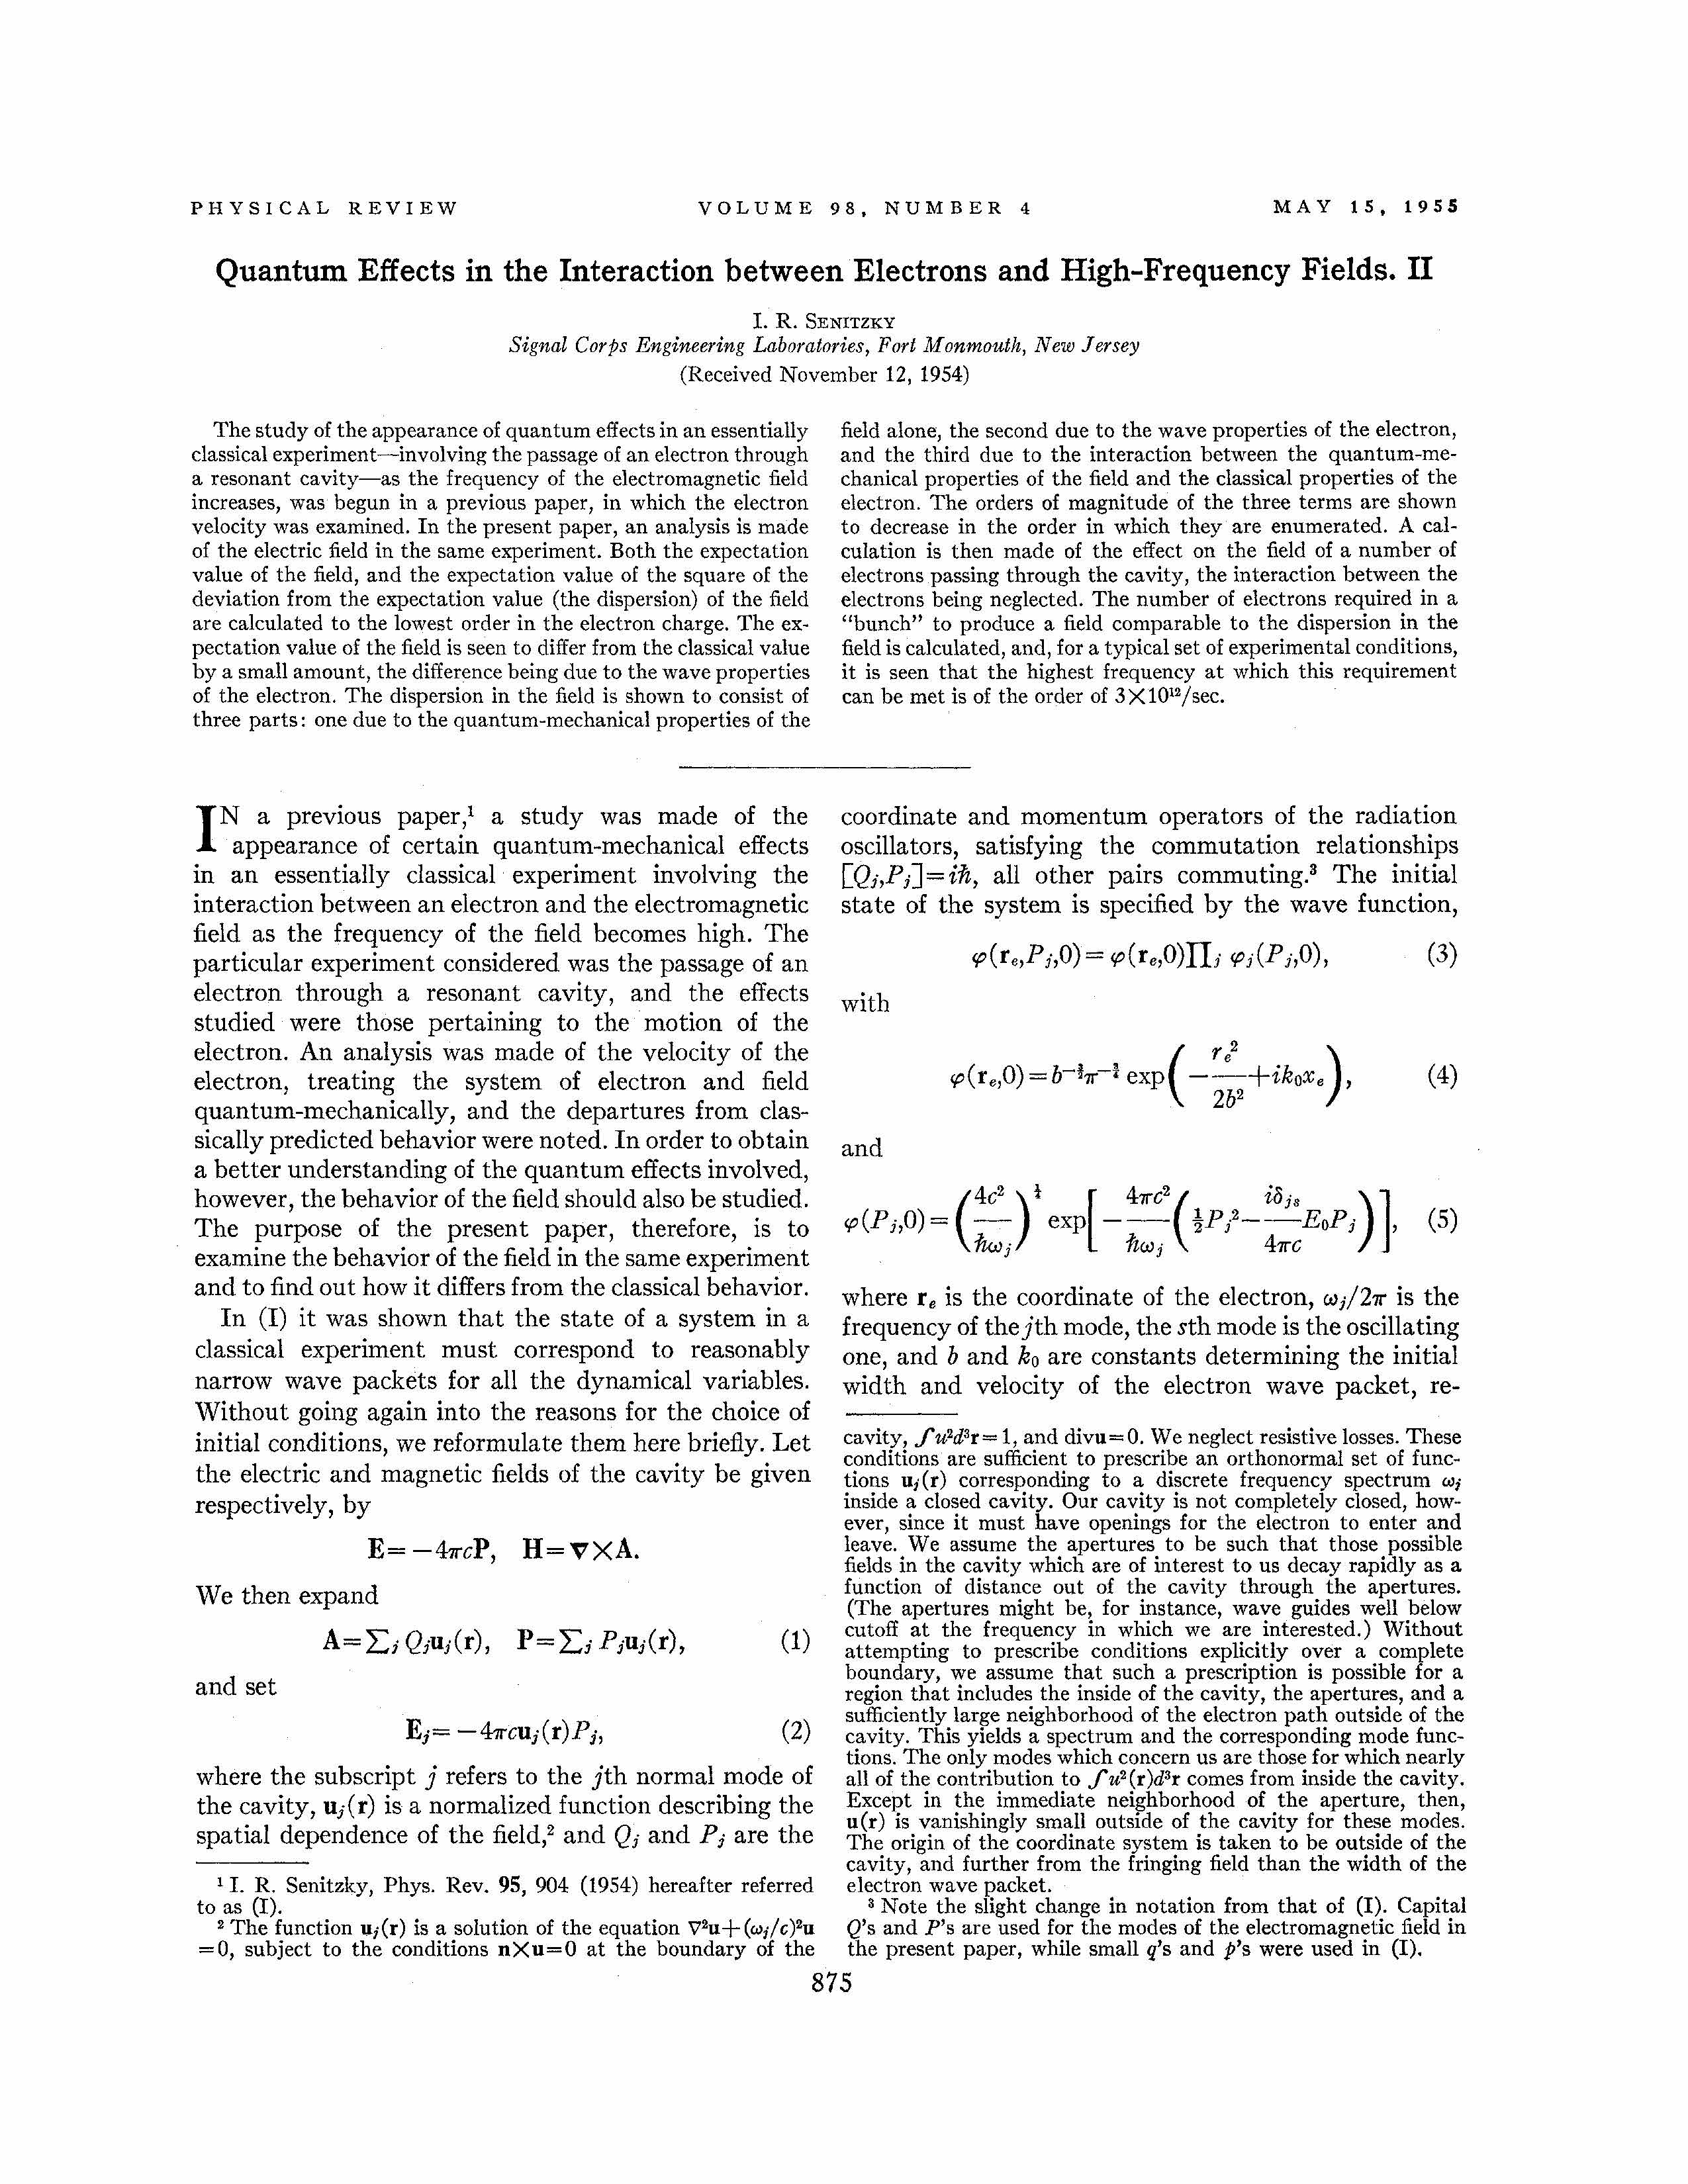

In [65]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [67]:
apsD2V.wv.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('reversed', 0.596064031124115),
 ('volts', 0.5815815925598145),
 ('reversing', 0.5674597024917603),
 ('steadily', 0.5643737316131592),
 ('electromagnetic', 0.5598033666610718)]

We can even look for documents most like a query composed of multiple words:

In [68]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.95.67', 0.5137767195701599),
 ('10.1103/PhysRev.99.786', 0.4898316264152527),
 ('10.1103/PhysRev.96.126', 0.4752596616744995),
 ('10.1103/PhysRev.106.261', 0.47187820076942444),
 ('10.1103/PhysRev.109.1892', 0.4686441123485565)]

Now let's plot some words and documents against one another with a heatmap:

In [69]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

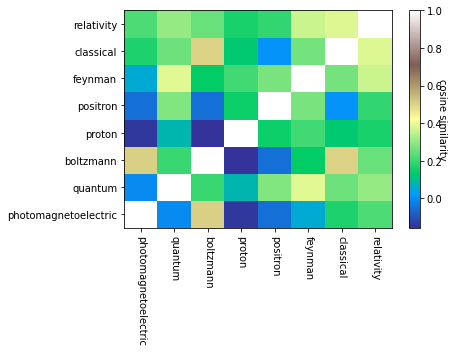

In [70]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [71]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

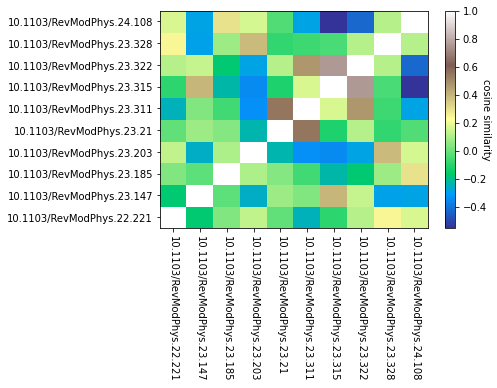

In [72]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [73]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

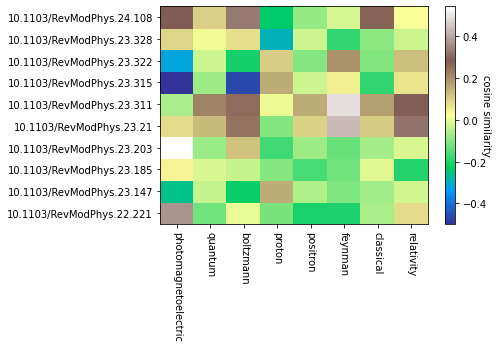

In [74]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [75]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

-----

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [173]:
leftTaggedDocs = []
for index, row in left_df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_sents'][0]]
    docKeywords.append(row['Unnamed: 0'])
    docKeywords.append(row['Media'])
    leftTaggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_sents'][0], tags = docKeywords))
left_df['TaggedAbstracts'] = leftTaggedDocs

C:\Users\86188\AppData\Local\Temp\ipykernel_50532\882011885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['TaggedAbstracts'] = leftTaggedDocs


In [174]:
rightTaggedDocs = []
for index, row in right_df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_sents'][0]]
    docKeywords.append(row['Unnamed: 0'])
    docKeywords.append(row['Media'])
    rightTaggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_sents'][0], tags = docKeywords))
right_df['TaggedAbstracts'] = rightTaggedDocs

C:\Users\86188\AppData\Local\Temp\ipykernel_50532\1802282580.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['TaggedAbstracts'] = rightTaggedDocs


In [175]:
leftD2V = gensim.models.doc2vec.Doc2Vec(left_df['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

In [176]:
rightD2V = gensim.models.doc2vec.Doc2Vec(right_df['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

In [121]:
leftD2V.wv.most_similar(positive = ['trump','democrat'], negative = ['republican'], topn = 1)

[('pence', 0.9951608180999756)]

In [140]:
rightD2V.wv.most_similar(positive = ['trump','democrat'], negative = ['republican'], topn = 2)

[('wednesday', 0.9988450407981873), ('ron', 0.9987671375274658)]

Again, I want to test how I would get from **trump + democrat - republican**. And...the left corpus returns me Pence, and the right corpus returns me Ron (DeSantis), two republicans...

In [147]:
leftD2V.docvecs.most_similar([leftD2V['election']], topn=5)

[('relativity', 0.9972492456436157),
 (3026, 0.9961445331573486),
 (30, 0.9958895444869995),
 (3036, 0.99579256772995),
 (576, 0.9957742691040039)]

I used the row index as the unique ID for each of the tweets, and...there seems to be something wrong with it, because I don't see where this "relativity" comes out...But any way, I got 4 normal index. Now let's check the 3026'th tweets.

In [154]:
tweets_df['Text'][3026]

'Nigeria’s Environmental Ministry declared a “major disaster” after a ship carrying more than 50,000 barrels of crude oil exploded off Nigeria’s coast, killing at least one crew member with seven others still missing.\nhttps://t.co/mzFsV3ITR2'

I'm not sure if it is a good answer...It seems not at all about election...

In [156]:
rightD2V.docvecs.most_similar([rightD2V['election']], topn=5)

[(6695, 0.9959940910339355),
 (6628, 0.995930016040802),
 (6635, 0.9953339099884033),
 (6085, 0.994546115398407),
 (7126, 0.9941334128379822)]

In [157]:
tweets_df['Text'][6695]

'After weeks of what appears to be politically motivated criticism, the Texas Military Department fired back with an official response to questions over pay issues, housing conditions, and suicide incidents. https://t.co/0x9i40hPq6'

This one seems to be more political!

Now let's pick a random tweet and see if Doc2Vec can find "related" tweets.

In [158]:
tweets_df['Text'][2361]

'Western governments are being called on to send more weapons to Ukraine — an arms buildup that will only escalate a potentially disastrous conflict. What we really need is a comprehensive peace settlement for the region. https://t.co/RMdkqjatpe'

This tweet is about Ukraine, weapon, war and peace from Jacobin.

In [163]:
leftD2V.wv.most_similar( [ leftD2V.docvecs[2361] ], topn=10) 

[('jet', 0.9918426275253296),
 ('journalist', 0.9915069341659546),
 ('plants', 0.9914808869361877),
 ('free', 0.9914743900299072),
 ('incidents', 0.9914575815200806),
 ('joint', 0.9914444088935852),
 ('account', 0.9913903474807739),
 ('republicans', 0.9913820624351501),
 ('putin', 0.9913552403450012),
 ('took', 0.9912892580032349)]

I think the Doc2Vec did a great job on it. It found "jet", "free", "incidents", "joint", even "putin".

Let's select another tweets in the right_df

In [165]:
tweets_df['Text'][5186]

'CLOSING TIME: @JesseBWatters applauds Americans for standing up against mandates, forcing Dems to give up pandemic hierarchy. https://t.co/Th4LaAWkMQ'

Wow this is a quite aggressive one.

In [166]:
rightD2V.wv.most_similar( [ rightD2V.docvecs[5186] ], topn=10) 

[('suspension', 0.9064695239067078),
 ('welcome', 0.9038437008857727),
 ('affairs', 0.9034126996994019),
 ('marc', 0.9026165008544922),
 ('tx', 0.9023926258087158),
 ('large', 0.9020372033119202),
 ('february', 0.9020271301269531),
 ('deadly', 0.9017040133476257),
 ('population', 0.9015812277793884),
 ('outrage', 0.9014695882797241)]

Unfortunately...We didn't see clear relevance between the particular tweet and the words returned by the algorithm. Maybe it's because the tweet is short and messed with mention and link.

In [168]:
keywords = ['election', 'trump', 'biden', 'school', 'china', 'people', 'world', 'american']

Now I want to use the heatmap to visualize the similarity among the 10 media.

In [180]:
tweetsTaggedDocs = []
for index, row in tweets_df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_sents'][0]]
    docKeywords.append(row['Unnamed: 0'])
    docKeywords.append(row['Media'])
    tweetsTaggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_sents'][0], tags = docKeywords))
tweets_df['TaggedAbstracts'] = tweetsTaggedDocs

In [181]:
tweetsD2V = gensim.models.doc2vec.Doc2Vec(tweets_df['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

In [177]:
media_list = ['CNN','thedailybeast','jacobin','democracynow','HuffPost','FoxNews','BreitbartNews','NRO','amspectator','NYPostOpinion']

In [182]:
heatmapMatrix = []
for tagOuter in media_list:
    column = []
    tagVec = tweetsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in media_list:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, tweetsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

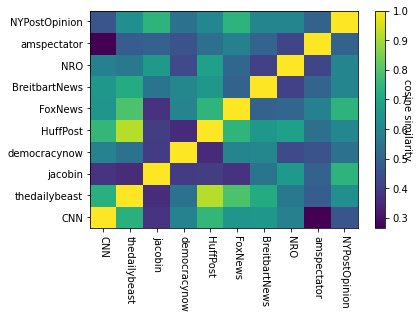

In [189]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix)
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(media_list, minor=False, rotation=270)
a = ax.set_yticklabels(media_list, minor=False)

It seems that there's no clear difference between tweets from left media and those from right media. By contrasts, the distance between media seems to be driven by other characteristics.

-----

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [190]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [191]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [192]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

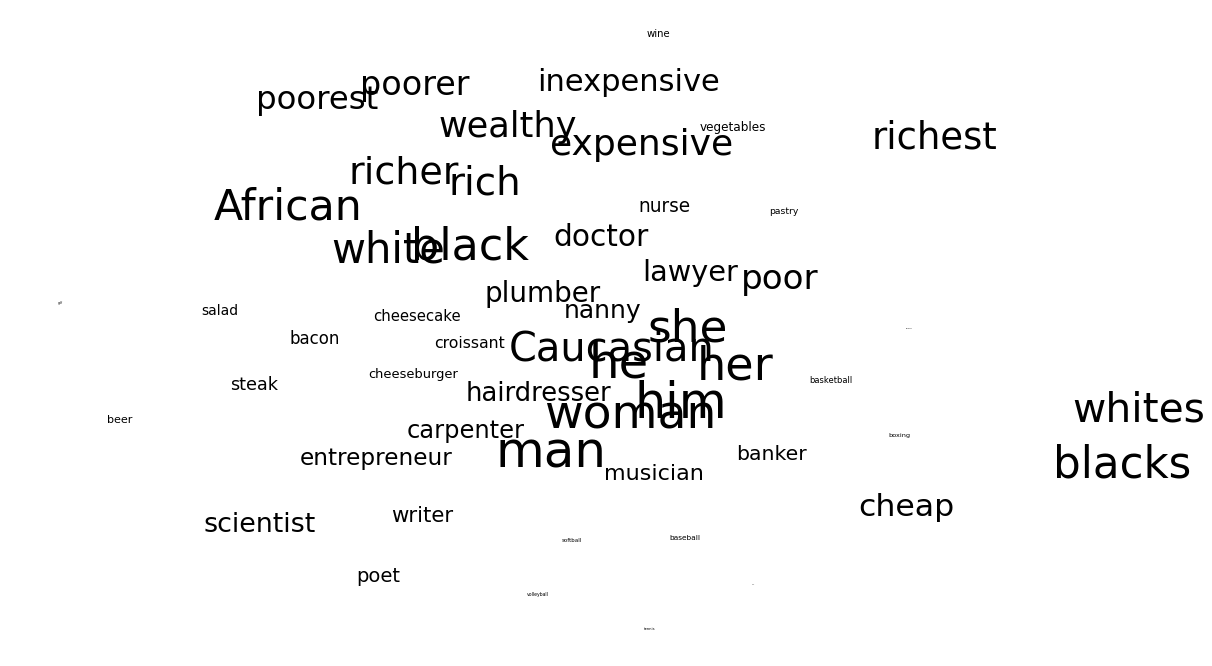

In [193]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [5]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [195]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [196]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [29]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [198]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [46]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

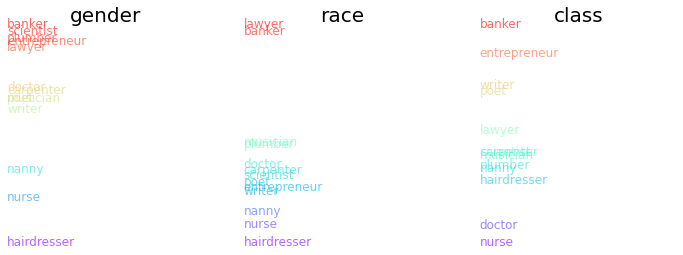

In [200]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

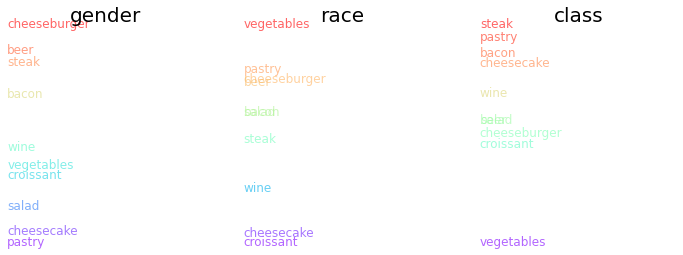

In [201]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

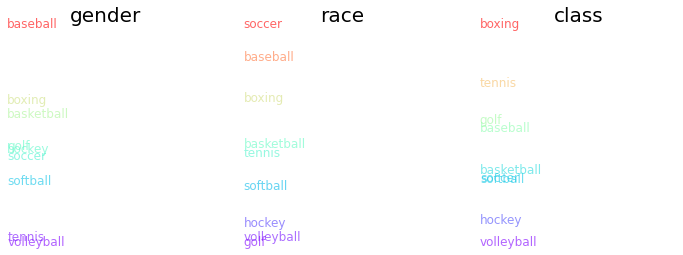

In [202]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

-----

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [7]:
tweetsW2V = gensim.models.word2vec.Word2Vec(tweets_df['normalized_sents'].sum(), sg=0)

In [233]:
#words to create dimensions
tnytTargetWords = ['safe','immigrants','young', 'old', 'boy', 'girl', 'tech','military','california', 'chicago', 'american', 'biden', 'trump', 'government', 'west', 'east', 'south', 'north', 'democrats', 'republicans','democrat', 'republican']
#words we will be mapping
tnytTargetWords += ["defund","police","movement","hero","people", "justice","ukraine","russian","president","hollywood", "elite","activists","working", "class", "values", "officers", "russia", "lives", "afford", "job", "florida", "woman", "man", "financial", "teacher", "protest", "demanding", "wages", "pension", "protection", "failed", "roosevelt"]

wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(tweetsW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [234]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

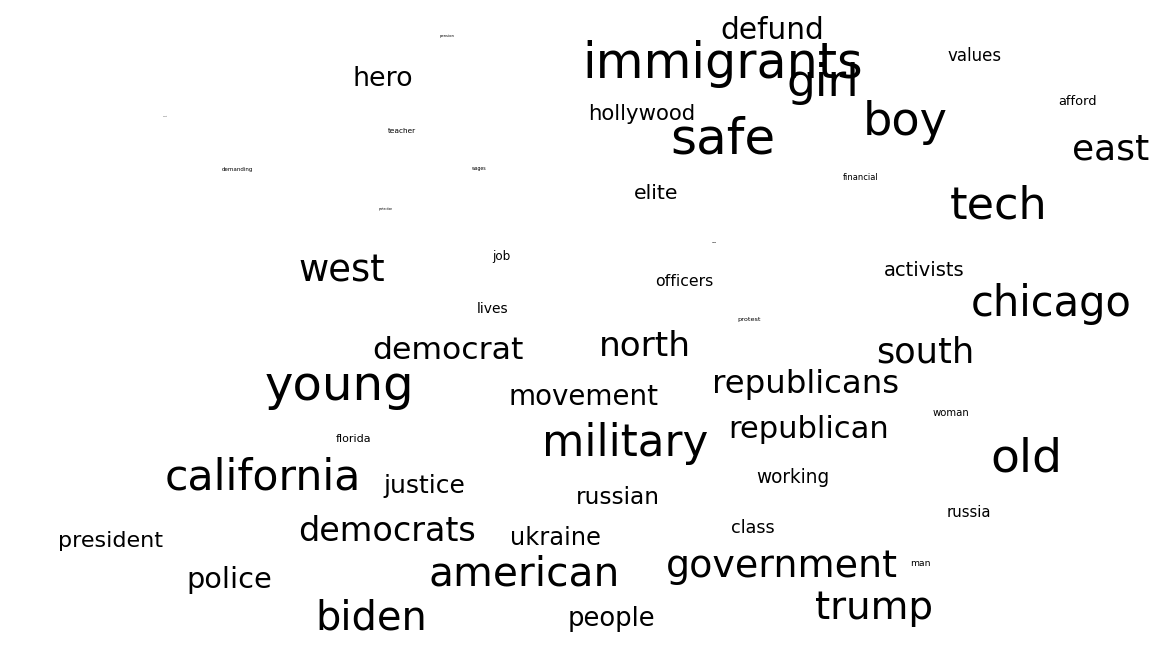

In [235]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

We see that the word "california" is close to "democrats", "justice", "young", "democrat", "west", which makes a lot of sense, but somehow "tech" is in the other side of the picture. The word "immigrants" is closely related with "safe", "girl" and "boy".

In [9]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model.wv[x]) for x in positives]) - sum([normalize(model.wv[y]) for y in negatives])
    return diff

In [52]:
Republican = dimension(tweetsW2V, ['republican','republicans'], ['democrat', 'democrats'])
Goodness = dimension(tweetsW2V, ['justice','correct','fair','good'], ['false', 'fake', 'wrong','bad'])
Newness = dimension(tweetsW2V, ['new', 'young'], ['old'])

In [27]:
tweets_df['Text'][2802]

'Web3 is touted as the next generation of the internet, promising to break the grip of giants like Google and Facebook. But far from empowering ordinary users, its token-based model threatens to commodify our online lives even further. https://t.co/OLdYmV4djU'

In [44]:
Nouns = ["facebook","man","woman","black","socialists", "racism","inequality","capitalists","mob","class", "internet","lawmaker","leaders"]

In [49]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(tweetsW2V.wv[word].reshape(1,-1), Republican.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(tweetsW2V.wv[word].reshape(1,-1), Goodness.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(tweetsW2V.wv[word].reshape(1,-1), Newness.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'republican': g, 'good': r, 'new': c}, index = word_list)
    return df

In [53]:
Nounsdf = makeDF(tweetsW2V, Nouns) 

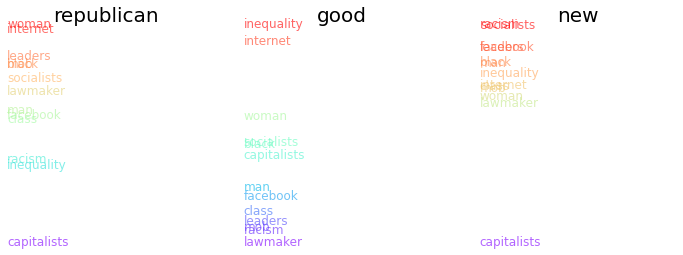

In [54]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Nounsdf, 'republican')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Nounsdf, 'good')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Nounsdf, 'new')
plt.show()

1. The fact that "woman" are more republican should be understand as that "woman" are often mentioned together with "republican", or in republican-related topics.
2. And "capitalists" is more democrate. That perhaps due to "capitalists" is often mentioned together with big companies.
3. "inequality" is good? Maybe we should understand it as that the "inequality" often occus together in a positive sentiment, such as "make contributions in tackling inequality".
4. "lawmakers", "leaders", "class" are all labeled as "bad", along with "racism". Maybe that's because they are often criticised.
5. Everything is new except for capitalists.

-----

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [64]:
resume_model  = gensim.models.KeyedVectors.load_word2vec_format('../data/supplement/resumeAll.model',binary=True)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

We can examine the vacabularies of this model by building a word-index map:

In [61]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [62]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [66]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [64]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [65]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [66]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [67]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [68]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [69]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [70]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


-----

You would increase the sample size if you want to do a more serious study.

## <font color="red">*Exercise 4a*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

In [65]:
vocab = tweetsW2V.wv.index_to_key

In [72]:
leftW2V1 = gensim.models.word2vec.Word2Vec(left_df['normalized_sents'].sum(), sg=0, hs=1, negative=0)
rightW2V1 = gensim.models.word2vec.Word2Vec(right_df['normalized_sents'].sum(), sg=0, hs=1, negative=0)

In [73]:
left_df['likelihood'] = left_df['normalized_sents'].apply(lambda x: adprob(x, leftW2V1))

C:\Users\86188\AppData\Local\Temp\ipykernel_73660\2717256686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['likelihood'] = left_df['normalized_sents'].apply(lambda x: adprob(x, leftW2V1))


In [98]:
right_df['likelihood'] = right_df['normalized_sents'].apply(lambda x: adprob(x, leftW2V1))

C:\Users\86188\AppData\Local\Temp\ipykernel_73660\1717201730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['likelihood'] = right_df['normalized_sents'].apply(lambda x: adprob(x, leftW2V1))


In [77]:
for ad in left_df.sort_values(by = 'likelihood', ascending = False)['Text'][:10]:
    print (ad)

Rihanna is expecting!
https://t.co/daINsUNoZr
Get cozy with elegant pajamas, slips, sweats, robes and much more. https://t.co/vJZnKFVvYG
Momma, he made it. https://t.co/eGTNGoICqV
https://t.co/DN2rRKZaVy
https://t.co/VrHvSicXzB
Not a neigh-sayer in sight. https://t.co/PQENLtU3Pf
No, it does not. https://t.co/q3zWwgIJEw
https://t.co/NDuH7wRCE0
When Debts Become Unpayable, They Should Be Forgiven https://t.co/il1hbPKOLg
No, it does not. https://t.co/q3zWwgIJEw


Well...It seems to not be a successful identifcation. All the tweets listed at top are short and meaningless sentence with link. I doubt that the link is the key.

In [80]:
for ad in left_df.sort_values(by = 'likelihood')['Text'][:5]:
    print (ad + '\n')

Today's top headlines: 
➡️ American Indian Movement co-founder Clyde Bellecourt dies at the age of 85
➡️ students in New York City stage walkouts to protest COVID protocols
➡️ the U.S. Navy agrees to shut down a storage fuel facility that contaminated a water supply in Hawaii https://t.co/02EeElc6Xk

Listen to the CNN 5 Things podcast for the latest on these top stories and more:

✔️ ISIS leader killed in US raid 
✔️ Canada truckers' protest declared "unlawful" 
✔️ Biden to visit NYC to combat gun violence 

https://t.co/9Z8kM5vv8U

Listen to the CNN 5 Things podcast for the latest on these top stories and more: 

✔️ Covid-19 vaccines for kids under 5 could come soon 
✔️ US Secretary of State call on Ukraine border tension 
✔️ Tom Brady's official announcement

https://t.co/kooxic0LCS

Citing a 65% drop in Covid-19 cases since the peak of the Omicron surge, California will end its statewide indoor mask mandate for vaccinated individuals next week, nearly two years after it was first im

That should be the most likely ones!

In [89]:
tweets_df['Text'][9353]

'The MTA’s coming fare sale is great — but straphangers won’t return until subways are safer https://t.co/NFqcjKdc7y https://t.co/VhcsjrtCbM'

In [81]:
adprob([["covid", "omicron"]], leftW2V1)

-15.747215

In [90]:
adprob([["crime", "police"]], leftW2V1)

-13.318145

In [87]:
adprob([["covid", "omicron"]], rightW2V1)

-13.871089

In [91]:
adprob([["crime", "police"]], rightW2V1)

-12.925043

Both left and right media seems to be talking more of the pandemic than security issues.

In [96]:
left_df.groupby("Media")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
Media,
HuffPost,-30.157738
jacobin,-39.025452
democracynow,-49.810173
thedailybeast,-53.653118
CNN,-63.538204


In [99]:
right_df.groupby("Media")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
Media,
amspectator,-24.303276
NYPostOpinion,-32.634502
BreitbartNews,-35.769527
NRO,-36.706188
FoxNews,-45.878033


This ranking may be taken as "skewness ranking" given by the algorithm. It indeed provides some interesting "opinions", though given only a small sample.

-----

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [76]:
import copy

In [71]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [72]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [73]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [94]:
ascoDF

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID,tokenized_sents,normalized_sents
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181,"[[Cisplatin, compound, is, established, as, th...","[[cisplatin, compound, establish, main, drug, ..."
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270,"[[Between, March, 24, 1977, and, March, 24, 19...","[[march, march, woman, primary, breast, cancer..."
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784,"[[ECF, has, established, activity, and, a, hig...","[[ecf, establish, activity, high, response, ra..."
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197,"[[In, 7/93, we, began, investigation, of, a, t...","[[begin, investigation, drug, combination, pac..."
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549,"[[Active, specific, immunotherapy, ASI, is, th...","[[active, specific, immunotherapy, asi, admini..."
5,1995,Breast Cancer,Validation of a model that identifies high ris...,GM Clark,Breast cancer patients with 10 or more positiv...,69,"[[Breast, cancer, patients, with, 10, or, more...","[[breast, cancer, patient, positive, lymph, no..."
6,1995,Genitourinary Cancer,Validation of the PROSQOLI: a pragmatic outcom...,M Stockler,Rationale: Traditional outcome measures are un...,649,"[[Rationale], [Traditional, outcome, measures,...","[[rationale], [traditional, outcome, measure, ..."
7,1995,Preclinical Experimental Therapeutics - Other,'In vitro' comparative assay on fluorouracil (...,A Abad,The clinical experience with biochemical modul...,1609,"[[The, clinical, experience, with, biochemical...","[[clinical, experience, biochemical, modulatio..."
8,1995,Tumor Biology,'Medical cultural diversity' among medical onc...,R Hochman,Most MO rely on prospective randomized trials....,1633,"[[Most, MO, rely, on, prospective, randomized,...","[[mo, rely, prospective, randomize, trial], [o..."
9,1995,Developmental TherapeuticsÑClinical Pharmacolo...,13-cis-retinoic acid plus low dose recombinant...,GM Turola,Both interferons and retinoids are known to po...,709,"[[Both, interferons, and, retinoids, are, know...","[[interferon, retinoid, know, possess, antipro..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [183]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [184]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [77]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [95]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [78]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


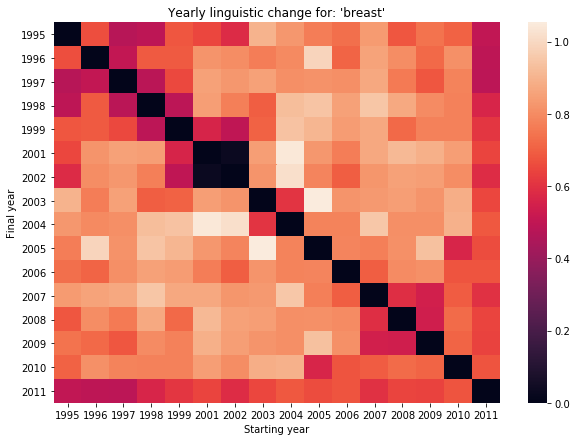

In [79]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


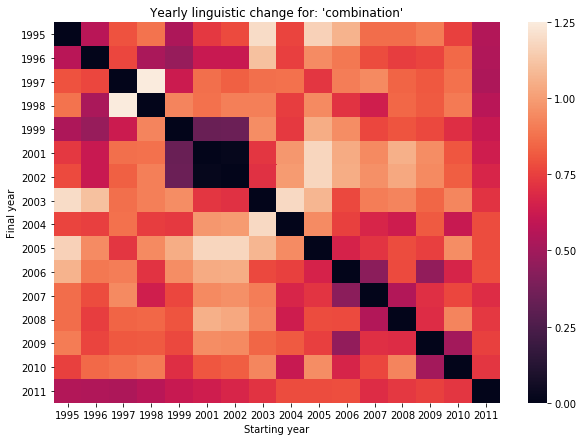

In [80]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [81]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [82]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [83]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [84]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


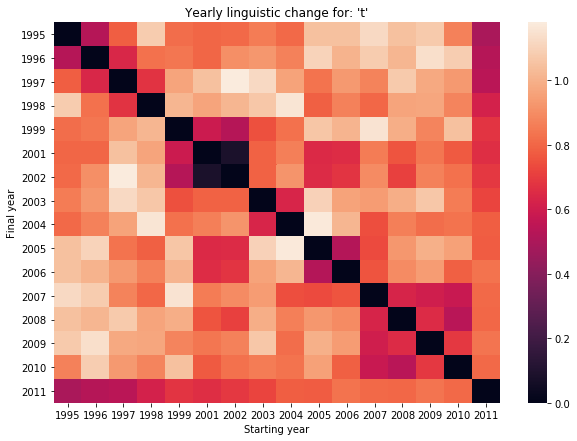

In [85]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

view


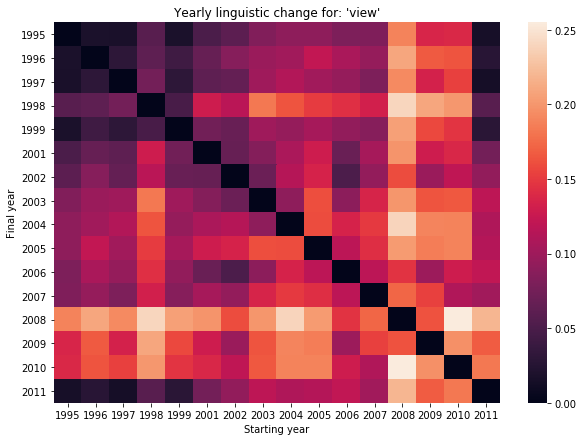

In [86]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [88]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [89]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [114]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [115]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue

We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [176]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [178]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [179]:
from gensim.models import Word2Vec

In [191]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [192]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [193]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [194]:
rawEmbeddings_epoch_load.keys()

dict_keys([0, 1, 2, 3, 4])

In [195]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <font color="red">*Exercise 4b*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

There is much more we do not have time to cover on word embeddings. If you are interested in other ways to align word embeddings, take a look at the [Dynamic Word Embeddings (DTM) section from the Thinking with Deep Learning course](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=COS_n2RFCJNk) or using the more recent [Temporal Word Embeddings with a Compass (TWEC) package](https://github.com/valedica/twec). There is also a useful section on [debiasing word embeddings](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=JHQ--EsWoxGM), such as the famous, ["Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520) paper. Below, we include an optional section on topic modeling with word embeddings, which could be useful for final projects.

## Optional: Topic modeling with word embeddings

Recently computer scientists have developed methods to cluster word embeddings, which can be viewed as a topic model, an embedding-based version of conventional topic models that use the document-term matrix (e.g., LDA). One method is Discourse Atoms, first described by Princeton NLP researchers ([Arora et al. 2018](https://arxiv.org/abs/1601.03764)). This uses k-SVD, a generalization of the k-means clustering algorithm to identify topic-like vectors in the n-dimensional word embedding space. Below is code adapted from the first social science paper using Discourse Atoms, [Arseniev-Koehler et al. 2021](https://osf.io/preprints/socarxiv/nkyaq/). It takes as input _gensim_ word vectors.

You are not required to implement this, but for class projects or your own research, this can be more useful than conventional topic models. It runs faster, produces more detailed topics, and in general makes use of more information (i.e., word order within a document) than do conventional topic models. Note there are at least 4 other papers with methods for word embedding clusters:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models](https://arxiv.org/abs/2004.14914)

Let's implement the Discourse Atoms method.

In [ ]:
# from gensim.test.utils import datapath 
# import re
# import string, re
# import cython

In [ ]:
# The ksvd package has a convenient Approximate k-SVD function.
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
# Load a gensim word2vec model
w2v = senReleasesW2V

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics. 




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document). 



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary, alpha = do_aksvd(w2v, 150, 5, save=True)

In [ ]:
topic_diversity(w2v, dictionary, top_n=25)

0.8885333333333333

In [ ]:
reconst_qual(w2v, dictionary, alpha)


(2398540.8915694184, 0.894244689800385, 0.4193311633201203)

In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


Discourse_Atom 0
['Egypts', 'Morsi', 'Morsi,', 'Morsis', 'Mubarak', 'Brotherhood', 'Egypt', 'Egyptian', 'ouster', 'coup', 'Islamist', 'Mohamed', 'Islamists', 'Egypt,', 'Cairo', 'generals', 'democratic', 'democracy.', 'ousted', 'legitimacy', 'Mahmoud', 'democracy', 'democracy,', 'Spring', 'Abdullah']


Discourse_Atom 1
['Derby', 'Triple', 'Belmont', 'Premier', 'Champions', 'Manchester', 'Crown', 'horse', 'League', 'winner,', 'horses', 'Real', 'Yankees', 'Yankees,', 'league', 'team', 'trainer', 'season', 'club', 'Chelsea', 'teams', 'Cup', 'Soccer', 'clubs', 'winning']


Discourse_Atom 2
['Brazil', 'Brazil,', 'Cup,', 'Cup', 'Germany', 'States,', 'countries', 'Cup.', 'Europe', 'Europe,', 'United', 'Portugal', 'countries,', 'nations,', 'Sweden', 'Argentina', 'Netherlands', 'World', 'Australia', 'Canada', 'Japan,', 'Africa', 'Germany,', 'States', 'Italy']


Discourse_Atom 3
['happened', 'moment', 'tragedy', 'story', 'happened.', 'tragic', 'nature', 'happened,', 'moments', 'truth', 'what', 'n

In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
w2v.wv.similar_by_vector(dictionary[112],topn=25)

[('court', 0.7905327081680298),
 ('judge', 0.7822369337081909),
 ('Court', 0.7414460182189941),
 ('courts', 0.7331409454345703),
 ('judges', 0.7240278124809265),
 ('Supreme', 0.7147840261459351),
 ('ruling', 0.711248517036438),
 ('case', 0.7036005854606628),
 ('appeals', 0.6984674334526062),
 ('Judge', 0.6953557729721069),
 ('lawyers', 0.681331992149353),
 ('ruling,', 0.6630173921585083),
 ('judge,', 0.6567955613136292),
 ('court,', 0.6532109975814819),
 ('plaintiffs', 0.6437978148460388),
 ('justices', 0.6303653717041016),
 ('legal', 0.6270549297332764),
 ('case,', 0.6229175329208374),
 ('ruling.', 0.6145539879798889),
 ('Court,', 0.6115553379058838),
 ('Circuit', 0.6098675727844238),
 ('court.', 0.6063867211341858),
 ('case.', 0.6011309623718262),
 ('trial', 0.5913736820220947),
 ('Justice', 0.5887668132781982)]

In [ ]:
print(w2v.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])



1 
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00273484 -0.00186215  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.00216819  0.          0.          0.          0.
  0.         -0.002954    0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.     

In [ ]:
#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0